<a href="https://colab.research.google.com/github/2303A52060/sml_assignments/blob/main/sml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parametric vs Non-parametric Density Estimation for Fraud Detection

   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0   

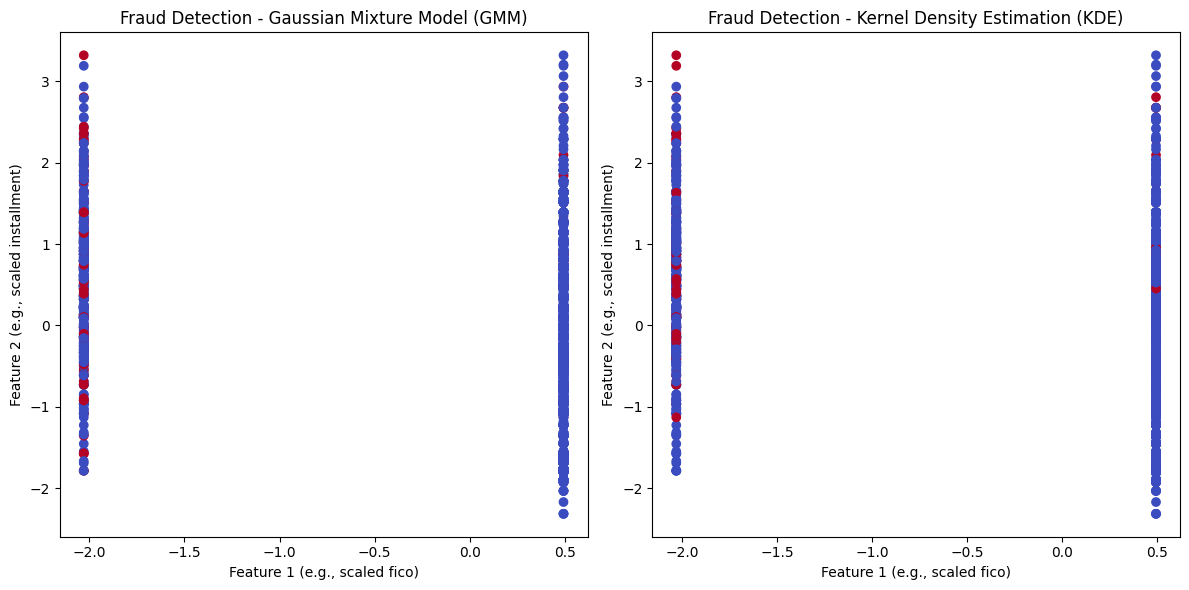

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from the specified path
df = pd.read_csv('loan_data.csv')  # Path to your CSV file

# Display the first few rows of the dataset to understand its structure
print(df.head())

# Data preprocessing
# Select relevant columns and handle any categorical features
df = df[['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
         'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
         'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']]

# Handle missing values (if any)
df = df.dropna()  # Drop rows with missing values (or fill if needed)

# Convert categorical variable 'purpose' into dummy/indicator variables
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

# Split the dataset into features (X) and target variable (y)
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data for better performance with GMM and KDE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Parametric Density Estimation (Gaussian Mixture Model) ---
# Fit a Gaussian Mixture Model (GMM) to the training data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_train_scaled)

# Calculate anomaly scores for the test data using the GMM
gmm_scores = -gmm.score_samples(X_test_scaled)  # Lower scores indicate higher likelihood of being fraud (non-payment)

# --- Non-Parametric Density Estimation (Kernel Density Estimation) ---
# Fit Kernel Density Estimation (KDE) to the training data
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X_train_scaled)

# Calculate anomaly scores for the test data using KDE
kde_scores = -kde.score_samples(X_test_scaled)  # Again, lower scores indicate higher likelihood of being fraud (non-payment)

# --- Thresholding and Anomaly Detection ---
# Define threshold for anomaly detection based on a chosen score cutoff
threshold = np.percentile(gmm_scores, 95)  # Consider top 5% of anomalies as fraud (non-payment)
gmm_predictions = (gmm_scores > threshold).astype(int)

threshold_kde = np.percentile(kde_scores, 95)  # Same threshold applied to KDE scores
kde_predictions = (kde_scores > threshold_kde).astype(int)

# --- Evaluation ---
from sklearn.metrics import classification_report, confusion_matrix

print("Gaussian Mixture Model (GMM) Evaluation:")
print(classification_report(y_test, gmm_predictions))
print(confusion_matrix(y_test, gmm_predictions))

print("Kernel Density Estimation (KDE) Evaluation:")
print(classification_report(y_test, kde_predictions))
print(confusion_matrix(y_test, kde_predictions))

# --- Visualization ---
# Plot the results of both GMM and KDE
plt.figure(figsize=(12, 6))

# GMM Visualization
plt.subplot(1, 2, 1)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=gmm_predictions, cmap='coolwarm', marker='o')
plt.title("Fraud Detection - Gaussian Mixture Model (GMM)")
plt.xlabel('Feature 1 (e.g., scaled fico)')
plt.ylabel('Feature 2 (e.g., scaled installment)')

# KDE Visualization
plt.subplot(1, 2, 2)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=kde_predictions, cmap='coolwarm', marker='o')
plt.title("Fraud Detection - Kernel Density Estimation (KDE)")
plt.xlabel('Feature 1 (e.g., scaled fico)')
plt.ylabel('Feature 2 (e.g., scaled installment)')

plt.tight_layout()
plt.show()
